# 1. feature extractor

In [1]:
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn.functional as F
from torch.amp import autocast
import clip
import encoding.utils as utils
from encoding.models.sseg import BaseNet

from feature_encoder.lseg_encoder.modules.lseg_module import LSegModule
from feature_encoder.lseg_encoder.additional_utils.encoding_models import MultiEvalModule as LSeg_MultiEvalModule
from collections import namedtuple

In [2]:
LSeg_args = namedtuple('LSeg_args', ['weights', 'data_path', 'dataset', 'backbone', 
                                     'aux', 'ignore_index', 'scale_inv', 'widehead',
                                     'widehead_hr', 'img_size', 'labels_path'])
adepallete = [0,0,0,120,120,120,180,120,120,6,230,230,80,50,50,4,200,3,120,120,80,140,140,140,204,5,255,230,230,230,4,250,7,224,5,255,235,255,7,150,5,61,120,120,70,8,255,51,255,6,82,143,255,140,204,255,4,255,51,7,204,70,3,0,102,200,61,230,250,255,6,51,11,102,255,255,7,71,255,9,224,9,7,230,220,220,220,255,9,92,112,9,255,8,255,214,7,255,224,255,184,6,10,255,71,255,41,10,7,255,255,224,255,8,102,8,255,255,61,6,255,194,7,255,122,8,0,255,20,255,8,41,255,5,153,6,51,255,235,12,255,160,150,20,0,163,255,140,140,140,250,10,15,20,255,0,31,255,0,255,31,0,255,224,0,153,255,0,0,0,255,255,71,0,0,235,255,0,173,255,31,0,255,11,200,200,255,82,0,0,255,245,0,61,255,0,255,112,0,255,133,255,0,0,255,163,0,255,102,0,194,255,0,0,143,255,51,255,0,0,82,255,0,255,41,0,255,173,10,0,255,173,255,0,0,255,153,255,92,0,255,0,255,255,0,245,255,0,102,255,173,0,255,0,20,255,184,184,0,31,255,0,255,61,0,71,255,255,0,204,0,255,194,0,255,82,0,10,255,0,112,255,51,0,255,0,194,255,0,122,255,0,255,163,255,153,0,0,255,10,255,112,0,143,255,0,82,0,255,163,255,0,255,235,0,8,184,170,133,0,255,0,255,92,184,0,255,255,0,31,0,184,255,0,214,255,255,0,112,92,255,0,0,224,255,112,224,255,70,184,160,163,0,255,153,0,255,71,255,0,255,0,163,255,204,0,255,0,143,0,255,235,133,255,0,255,0,235,245,0,255,255,0,122,255,245,0,10,190,212,214,255,0,0,204,255,20,0,255,255,255,0,0,153,255,0,41,255,0,255,204,41,0,255,41,255,0,173,0,255,0,245,255,71,0,255,122,0,255,0,255,184,0,92,255,184,255,0,0,133,255,255,214,0,25,194,194,102,255,0,92,0,255]

def get_labels(dataset, root_path=None):
    labels = []
    # NOTE：
    if root_path is None:
        path = 'label_files/{}_objectInfo150.txt'.format(dataset)
    else:
        path = root_path + '/label_files/{}_objectInfo150.txt'.format(dataset)
    assert os.path.exists(path), '*** Error : {} not exist !!!'.format(path)
    f = open(path, 'r') 
    lines = f.readlines()      
    for line in lines: 
        label = line.strip().split(',')[-1].split(';')[0]
        labels.append(label)
    f.close()
    if dataset in ['ade20k']:
        labels = labels[1:]
    return labels

def get_legend_patch(npimg, new_palette, labels):
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    out_img.putpalette(new_palette)
    u_index = np.unique(npimg)
    patches = []
    for i, index in enumerate(u_index):
        label = labels[index]
        cur_color = [new_palette[index * 3] / 255.0, new_palette[index * 3 + 1] / 255.0, new_palette[index * 3 + 2] / 255.0]
        red_patch = mpatches.Patch(color=cur_color, label=label)
        patches.append(red_patch)
    return out_img, patches

class LSeg_FeatureExtractor(torch.nn.Module):
    def __init__(self, debug=False):
        super(LSeg_FeatureExtractor, self).__init__()
        self.debug = debug
        args = LSeg_args(weights='/home/MonoGS_Semantic/checkpoints/demo_e200.ckpt', 
                        data_path=None, 
                        dataset='ignore', 
                        backbone='clip_vitl16_384',
                        aux=False,
                        ignore_index = 255,
                        scale_inv=False,
                        widehead=True,
                        widehead_hr=False,
                        img_size=[480, 360],
                        labels_path='/home/MonoGS_Semantic/feature_encoder/lseg_encoder')
        
        module = LSegModule.load_from_checkpoint(
            checkpoint_path=args.weights,
            data_path=args.data_path,
            dataset=args.dataset,
            backbone=args.backbone,
            aux=args.aux,
            num_features=256,
            aux_weight=0,
            se_loss=False,
            se_weight=0,
            base_lr=0,
            batch_size=1,
            max_epochs=0,
            ignore_index=args.ignore_index,
            dropout=0.0,
            scale_inv=args.scale_inv,
            augment=False,
            no_batchnorm=False,
            widehead=args.widehead,
            widehead_hr=args.widehead_hr,
            map_locatin="cpu",
            arch_option=0,
            block_depth=0,
            activation='lrelu',
            labels_path=args.labels_path
        )
        self.labels = get_labels('ade20k', root_path=args.labels_path)
        self.input_transform = module.val_transform
        self.num_classes = len(self.labels)
        
        if isinstance(module.net, BaseNet):
            model = module.net
        else:
            model = module
            
        model = model.eval()
        model = model.cpu()
        model = model.half()
        # self._log(model)
        
        self.scales = [0.75, 1.0, 1.25, 1.75]
        self.img_size = args.img_size
        self._log(f"scales: {self.scales}")
        self._log(f"img_size: {self.img_size}")
        
        self.evaluator = LSeg_MultiEvalModule(model, self.num_classes, scales=self.scales, flip=True).cuda()
        self.evaluator.eval()
        self.evaluator.half()
    
    def _log(self, text):
        if self.debug:
            print(f"[Debug--LSeg_FeatureExtractor]{text}")
    
    @torch.no_grad()
    def preprocess(self, image):
        if isinstance(image, str):
            image = Image.open(image).convert('RGB')
            image = self.input_transform(image).unsqueeze(0)
        elif isinstance(image, np.ndarray):
            image = Image.fromarray(image)
            image = self.input_transform(image).unsqueeze(0)
        elif isinstance(image, torch.Tensor):
            if image.dim() == 3:
                image = image.unsqueeze(0)
            elif image.dim() == 4:
                pass
            else:
                raise ValueError("Unsupported input shape. Supported shapes: (C, H, W), (1, C, H, W)")
        else:
            raise ValueError("Unsupported input type. Supported types: str (file path), numpy.ndarray, torch.Tensor")
        # self._log(f"input size: {image.shape}")
        image = F.interpolate(image, size=(self.img_size[0], self.img_size[1]),
                                      mode="bilinear", align_corners=True)
        # self._log(f"resize size: {image.shape}")
        return image.half()
    
    @torch.no_grad()
    def forward_feature(self, image: torch.Tensor) -> np.ndarray:
        with autocast("cuda"):
            output_features = self.evaluator.parallel_forward(image, return_feature=True)
            # self._log(f"resize output_features: {output_features[0].shape}")
            return output_features[0] # .cpu().numpy().astype(np.float16)
        
    @torch.no_grad()
    def forward(self, image):
        with autocast("cuda"):
            time_start = time.time()
            image_tensor = self.preprocess(image)
            feature = self.forward_feature(image_tensor)
            numpy_feature = feature.cpu().numpy().astype(np.float16)
            rgb_render, patches = self.features_to_image(feature) # free memory
            self._log(f"output_features: {numpy_feature.shape} forward time: {time.time() - time_start}")
            return numpy_feature, rgb_render, patches
        
    @torch.no_grad()
    def features_to_image(self, image_features: torch.Tensor, labels_set = None):
        with autocast("cuda"):
            if len(image_features.shape) == 3:
                image_features = image_features.unsqueeze(0)
            elif len(image_features.shape) == 4:
                pass 
            else:
                raise ValueError("Unsupported input shape. Supported shapes: (C, H, W), (1, C, H, W)")
            imshape = image_features.shape
            feature_dim = imshape[1]
            image_features = image_features.half()
            image_features = image_features.permute(0,2,3,1).reshape(-1, feature_dim)
            if labels_set is None or len(labels_set) == 0:
                text_features = self.evaluator.module.net.clip_pretrained.encode_text(self.evaluator.module.net.text.cuda())
                labels_set = self.labels
            else:
                text = clip.tokenize(labels_set)  
                text_features = self.evaluator.module.net.clip_pretrained.encode_text(text.cuda())
            # self._log(f"image_features: {image_features.shape}, text_features: {text_features.shape}")
            # normalized features
            image_features = image_features / image_features.norm(dim=-1, keepdim=True) 
            text_features = text_features / text_features.norm(dim=-1, keepdim=True) 
            
            logits_per_image = self.evaluator.module.net.logit_scale * image_features @ text_features.t() 
            out = logits_per_image.float().view(imshape[0], imshape[2], imshape[3], -1).permute(0,3,1,2) 
            predicts = torch.max(out, 1)[1].cpu().numpy()
            rgb_render, patches = get_legend_patch(predicts, adepallete, labels_set)
            rgb_render = rgb_render.convert("RGBA")
            del image_features, text_features, logits_per_image, out
            torch.cuda.empty_cache()
            return np.array(rgb_render), patches
    
    def draw_patches(self, patches, save_path):
        plt.figure()
        plt.axis('off')
        plt.legend(handles=patches, prop={'size': 8}, ncol=4)
        plt.savefig(save_path, format="png", dpi=300, bbox_inches="tight")
        plt.clf() # Clear the current figure
        plt.close() # Close the current figure

    @torch.no_grad()
    def vis_feature(self, image, outname='test', outdir='vis'):
        with autocast("cuda"):
            image_tensor = self.preprocess(image)
            outputs = self.evaluator.parallel_forward(image_tensor)[0]
            predicts = torch.max(outputs, 1)[1].cpu().numpy()
            
            # save mask
            masks = utils.get_mask_pallete(predicts, 'detail')
            masks.save(os.path.join(outdir, outname+'.png'))
            
            # save vis
            masks_tensor = torch.tensor(np.array(masks.convert("RGB"), "f")) / 255.0
            vis_img = (image_tensor[0] + 1) / 2.
            vis_img = vis_img.permute(1, 2, 0)  # ->hwc
            vis1 = vis_img
            vis2 = vis_img * 0.4 + masks_tensor * 0.6
            vis3 = masks_tensor
            vis = torch.cat([vis1, vis2, vis3], dim=1)
            Image.fromarray((vis.cpu().numpy() * 255).astype(np.uint8)).save(os.path.join(outdir, outname+"_vis.png"))

            # save label vis
            seg, patches = get_legend_patch(predicts, adepallete, self.labels)
            seg = seg.convert("RGBA")
            plt.figure()
            plt.axis('off')
            plt.imshow(seg)
            plt.legend(handles=patches, prop={'size': 8}, ncol=4)
            plt.savefig(os.path.join(outdir, outname+"_legend.png"), format="png", dpi=300, bbox_inches="tight")
            plt.clf()
            plt.close()

In [3]:

lseg = LSeg_FeatureExtractor(debug=True)


** Use norm [0.5, 0.5, 0.5], [0.5, 0.5, 0.5] as the mean and std **
[Debug--LSeg_FeatureExtractor]scales: [0.75, 1.0, 1.25, 1.75]
[Debug--LSeg_FeatureExtractor]img_size: [480, 360]
MultiEvalModule: base_size 520, crop_size 480


In [ ]:
test_image_path = "/home/data/datasets/replica/room0/results/frame000001.jpg"
lseg.preprocess(test_image_path)
lseg.vis_feature(test_image_path)

tensor([[[[0.6313, 0.6260, 0.6313,  ..., 0.2942, 0.2942, 0.2864],
          [0.6328, 0.6333, 0.6343,  ..., 0.2942, 0.2957, 0.2817],
          [0.6235, 0.6411, 0.6401,  ..., 0.2942, 0.2942, 0.2864],
          ...,
          [0.4182, 0.4121, 0.4021,  ..., 0.7456, 0.7651, 0.7427],
          [0.4119, 0.4082, 0.3933,  ..., 0.7349, 0.7437, 0.7446],
          [0.4119, 0.4038, 0.4014,  ..., 0.7070, 0.7021, 0.7334]],

         [[0.3491, 0.3518, 0.3491,  ..., 0.2079, 0.2079, 0.2000],
          [0.3601, 0.3560, 0.3521,  ..., 0.2079, 0.2094, 0.1954],
          [0.3647, 0.3586, 0.3577,  ..., 0.2079, 0.2079, 0.2000],
          ...,
          [0.2379, 0.2318, 0.2218,  ..., 0.3923, 0.4175, 0.3896],
          [0.2313, 0.2279, 0.2129,  ..., 0.3865, 0.3972, 0.3916],
          [0.2313, 0.2235, 0.2211,  ..., 0.3618, 0.3569, 0.3804]],

         [[0.2549, 0.2495, 0.2549,  ..., 0.2705, 0.2549, 0.2471],
          [0.2561, 0.2505, 0.2581,  ..., 0.2642, 0.2563, 0.2490],
          [0.2471, 0.2487, 0.2634,  ..., 0

# 2. feature decoder

In [1]:
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast
import clip

adepallete = [0,0,0,120,120,120,180,120,120,6,230,230,80,50,50,4,200,3,120,120,80,140,140,140,204,5,255,230,230,230,4,250,7,224,5,255,235,255,7,150,5,61,120,120,70,8,255,51,255,6,82,143,255,140,204,255,4,255,51,7,204,70,3,0,102,200,61,230,250,255,6,51,11,102,255,255,7,71,255,9,224,9,7,230,220,220,220,255,9,92,112,9,255,8,255,214,7,255,224,255,184,6,10,255,71,255,41,10,7,255,255,224,255,8,102,8,255,255,61,6,255,194,7,255,122,8,0,255,20,255,8,41,255,5,153,6,51,255,235,12,255,160,150,20,0,163,255,140,140,140,250,10,15,20,255,0,31,255,0,255,31,0,255,224,0,153,255,0,0,0,255,255,71,0,0,235,255,0,173,255,31,0,255,11,200,200,255,82,0,0,255,245,0,61,255,0,255,112,0,255,133,255,0,0,255,163,0,255,102,0,194,255,0,0,143,255,51,255,0,0,82,255,0,255,41,0,255,173,10,0,255,173,255,0,0,255,153,255,92,0,255,0,255,255,0,245,255,0,102,255,173,0,255,0,20,255,184,184,0,31,255,0,255,61,0,71,255,255,0,204,0,255,194,0,255,82,0,10,255,0,112,255,51,0,255,0,194,255,0,122,255,0,255,163,255,153,0,0,255,10,255,112,0,143,255,0,82,0,255,163,255,0,255,235,0,8,184,170,133,0,255,0,255,92,184,0,255,255,0,31,0,184,255,0,214,255,255,0,112,92,255,0,0,224,255,112,224,255,70,184,160,163,0,255,153,0,255,71,255,0,255,0,163,255,204,0,255,0,143,0,255,235,133,255,0,255,0,235,245,0,255,255,0,122,255,245,0,10,190,212,214,255,0,0,204,255,20,0,255,255,255,0,0,153,255,0,41,255,0,255,204,41,0,255,41,255,0,173,0,255,0,245,255,71,0,255,122,0,255,0,255,184,0,92,255,184,255,0,0,133,255,255,214,0,25,194,194,102,255,0,92,0,255]


def get_labels(dataset, root_path=None):
    labels = []
    # NOTE：
    if root_path is None:
        path = 'label_files/{}_objectInfo150.txt'.format(dataset)
    else:
        path = root_path + '/label_files/{}_objectInfo150.txt'.format(dataset)
    assert os.path.exists(path), '*** Error : {} not exist !!!'.format(path)
    f = open(path, 'r') 
    lines = f.readlines()      
    for line in lines: 
        label = line.strip().split(',')[-1].split(';')[0]
        labels.append(label)
    f.close()
    if dataset in ['ade20k']:
        labels = labels[1:]
    return labels

def get_legend_patch(npimg, new_palette, labels):
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    out_img.putpalette(new_palette)
    u_index = np.unique(npimg)
    patches = []
    for i, index in enumerate(u_index):
        label = labels[index]
        cur_color = [new_palette[index * 3] / 255.0, new_palette[index * 3 + 1] / 255.0, new_palette[index * 3 + 2] / 255.0]
        red_patch = mpatches.Patch(color=cur_color, label=label)
        patches.append(red_patch)
    return out_img, patches


In [2]:
class LSeg_FeatureDecoder(torch.nn.Module):
    def __init__(self, debug=False):
        super(LSeg_FeatureDecoder, self).__init__()
        self.debug = debug
        args_labels_path = 'feature_encoder/lseg_encoder'
        self.clip_pretrained, _ = clip.load("ViT-B/32", device='cuda', jit=False, download_root="/tmp/")
        self.clip_pretrained.eval()
        self.labels = get_labels('ade20k', root_path=args_labels_path)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07)).exp()
        self.logit_scale.to('cuda')
    
    @torch.no_grad()
    def features_to_image(self, image_features: torch.Tensor, labels_set = None):
        with autocast("cuda"):
            if len(image_features.shape) == 3:
                image_features = image_features.unsqueeze(0)
            elif len(image_features.shape) == 4:
                pass 
            else:
                raise ValueError("Unsupported input shape. Supported shapes: (C, H, W), (1, C, H, W)")
            
            imshape = image_features.shape
            feature_dim = imshape[1]
            image_features = image_features.half()
            image_features = image_features.permute(0,2,3,1).reshape(-1, feature_dim)
            if labels_set is None or len(labels_set) == 0:
                labels_set = self.labels
            text = clip.tokenize(labels_set)  
            text_features = self.clip_pretrained.encode_text(text.cuda())
            # normalized features
            image_features = image_features / image_features.norm(dim=-1, keepdim=True) 
            text_features = text_features / text_features.norm(dim=-1, keepdim=True) 
            
            logits_per_image = self.logit_scale * image_features @ text_features.t() 
            out = logits_per_image.float().view(imshape[0], imshape[2], imshape[3], -1).permute(0,3,1,2) 
            predicts = torch.max(out, 1)[1].cpu().numpy()
            rgb_render, patches = get_legend_patch(predicts, adepallete, labels_set)
            rgb_render = rgb_render.convert("RGBA")
            del image_features, text_features, logits_per_image, out
            torch.cuda.empty_cache()
        return np.array(rgb_render), patches

In [3]:
decoder = LSeg_FeatureDecoder(debug=True)
feature_map_render = torch.load('feature_map.pt')
print(feature_map_render.shape)

torch.Size([512, 360, 480])


/tmp/ipykernel_240564/711199401.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature_map_render = torch.load('feature_map.pt')


decoder time: 0.09133410453796387


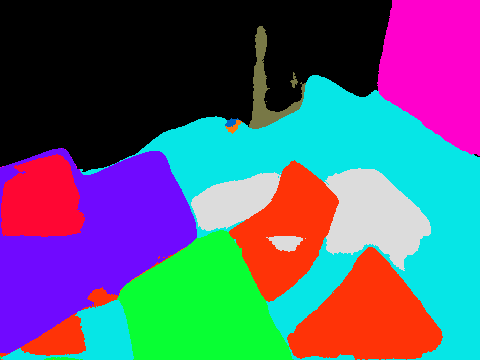

In [11]:

start_time = time.time()
image, _ = decoder.features_to_image(feature_map_render)
print(f"decoder time: {time.time() - start_time}")
Image.fromarray(image)